In [6]:
import sisl
from ase.build import molecule
from ase.visualize import view
from tqdm.notebook import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as sciopt
from Block_matrices.Block_matrices import block_td, block_sparse, Interpolate, Blocksparse2Numpy
from nanobtl.trans import *
from nanobtl.cap import *
from time import time

In [7]:
plt.rcParams["figure.figsize"] = (20,7)

# Input generation

## Geometry & Hamiltonian

Parameters

In [8]:
R = [0.1, 1.5]
hop = [0., -2.75] #on-site and hopping element in eV
bond = 1.42       #distance between 2 atoms in Angstrom
Nc_elec = 10      #number of graphene cells tiled
Ntrans  = 1
h = -1.           #hopping element of defect between 2 mid carbon atoms
axis = 0
bc_axis = 1

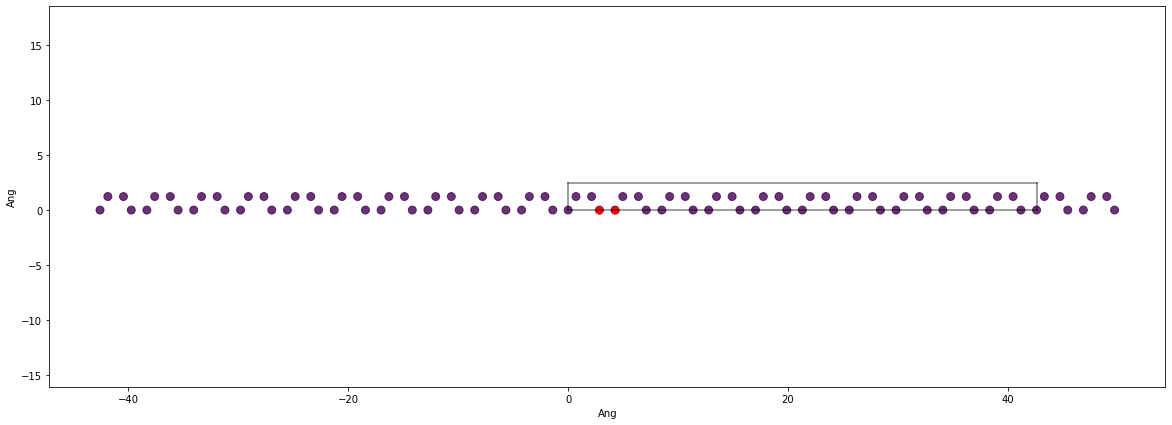

In [9]:
#Geometry
gr_er = sisl.geom.graphene(bond=bond, orthogonal = True).tile(Ntrans,1).tile(Nc_elec,0)
gr_el = gr_er.mirror('yz').translate([-4.2/3,0,0]) #mirror to generate a symmetric geometry necessary for optimization
gr_dev_only = sisl.geom.graphene(bond=bond, orthogonal = True).tile(Ntrans,1).tile(2,0)
gr_dev = gr_el.add(gr_dev_only).add(gr_er.translate(gr_dev_only.cell[axis]))

#Atomic number of the 2 middle carbon atoms for the defect
nbond = []
Nc_dev = 2*Nc_elec+2
for i in range(Ntrans):
    nbond.append((2*Ntrans*(Nc_dev-2)+3+4*i,2*Ntrans*Nc_dev+4*i))    

#Construction of Hamiltonians
H_er = sisl.Hamiltonian(gr_er)
H_er.construct((R,hop))
H_dev = sisl.Hamiltonian(gr_dev)
H_dev.construct((R,hop))
H_el = sisl.Hamiltonian(gr_el)
H_el.construct((R,hop))

H_dev.set_nsc([1,3,1])

#Plotting the geometry
sisl.plot(gr_dev) ; plt.axis("equal")

#Modifying the hopping element between the middle carbon atoms
for i,j in nbond:
    H_dev.H[i,j], H_dev.H[j,i] = h, h
    
    plt.scatter(gr_dev[i,0], gr_dev[i,1], c="r", s=50) #modified bond are in red
    plt.scatter(gr_dev[j,0], gr_dev[j,1], c="r", s=50)

#Saving the hamiltonians as .TSHS files
H_el.write("./geom/grh_10_el.TSHS")
H_er.write('./geom/grh_10_er.TSHS')
H_dev.write('./geom/grh1_10_dev.TSHS')

## Objective Transmission

For the objective transmission, the self-energy of the electrodes is computed by recursion, therefore 1 cell is sufficient : redifining the geometry to speed up computation

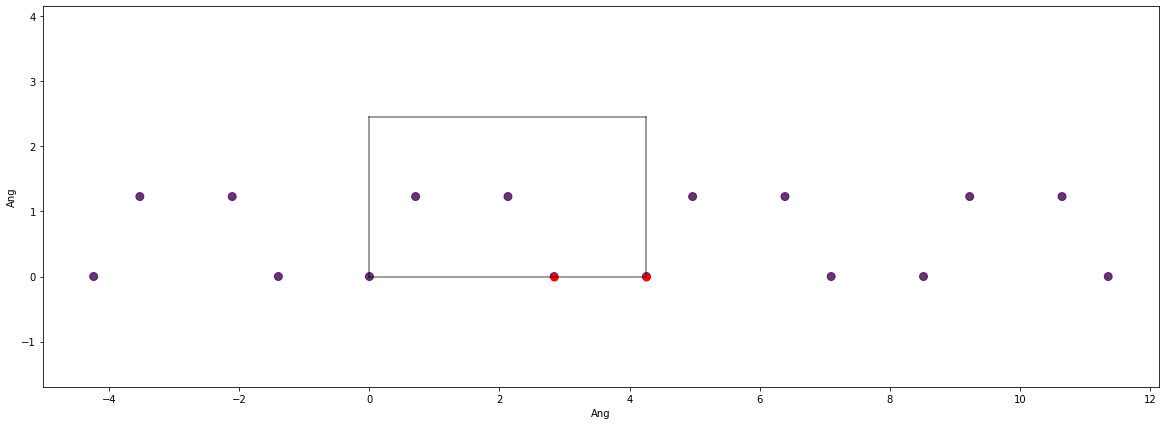

In [10]:
#Geometry
gr_er_obj = sisl.geom.graphene(bond=bond, orthogonal = True).tile(Ntrans,1)
gr_el_obj = gr_er_obj.mirror('yz').translate([-4.2/3,0,0]) #mirror to generate a symmetric geometry necessary for optimization
gr_dev_only = sisl.geom.graphene(bond=bond, orthogonal = True).tile(Ntrans,1).tile(2,0)
gr_dev_obj = gr_el_obj.add(gr_dev_only).add(gr_er_obj.translate(gr_dev_only.cell[axis]))

#Atomic number of the 2 middle carbon atoms for the defect
nbond_obj = []
for i in range(Ntrans):
    nbond_obj.append((4*Ntrans+3+4*i,8*Ntrans+4*i))    

#Construction of Hamiltonians
H_er_obj = sisl.Hamiltonian(gr_er_obj)
H_er_obj.construct((R,hop))
H_dev_obj = sisl.Hamiltonian(gr_dev_obj)
H_dev_obj.construct((R,hop))
H_el_obj = sisl.Hamiltonian(gr_el_obj)
H_el_obj.construct((R,hop))

H_dev_obj.set_nsc([1,3,1])

#Plotting the geometry
sisl.plot(gr_dev_obj) ; plt.axis("equal")

#Modifying the hopping element between the middle carbon atoms
for i,j in nbond_obj:
    H_dev_obj.H[i,j], H_dev_obj.H[j,i] = h, h
    
    plt.scatter(gr_dev_obj[i,0], gr_dev_obj[i,1], c="r", s=50) #modified bond are in red
    plt.scatter(gr_dev_obj[j,0], gr_dev_obj[j,1], c="r", s=50)

It is important to play on kmin, kmax, nk, Emin, Emax, ne to catch all the features of the transmission into T_obj, while minimizing the number of energy and k points (optimization time is proportional to ne*nk)

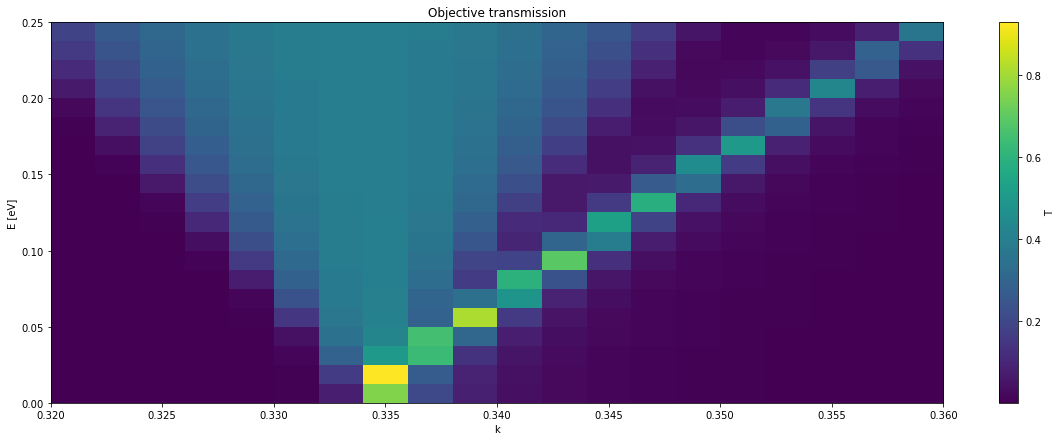

In [11]:
Emin = 0.
Emax = 0.25
ne   = 20
kmin = 0.32
kmax = 0.36
nk   = 20
E    = np.linspace(Emin,Emax,ne)
K    = np.linspace(kmin,kmax,nk)
axis = 0
eta_obj = 1e-2

H_center_plus_obj = matrix_elements(H_dev_obj, pdir = bc_axis, tdir = axis, which=0 )
H_left_obj    = matrix_elements(H_el_obj,pdir = bc_axis, tdir = axis,which = 0)
V_left_obj    = matrix_elements(H_el_obj,pdir = bc_axis, tdir = axis,which = -1)
H_right_obj   = matrix_elements(H_er_obj,pdir = bc_axis, tdir = axis,which = 0)
V_right_obj   = matrix_elements(H_er_obj,pdir = bc_axis, tdir = axis,which = 1)

T_obj = trans(E, K, H_left_obj, V_left_obj, H_center_plus_obj, H_right_obj, V_right_obj, eavg=False, kavg=False, eta=eta_obj).real

np.save("./Tobj/Tobj_grh1_20-0-025_20-032-036.npy",T_obj) #save

plt.title("Objective transmission")
plt.imshow(np.flip(T_obj, axis=0), aspect="auto", extent=[kmin, kmax, Emin, Emax])
plt.colorbar(label="T")
plt.xlabel("k")
plt.ylabel('E [eV]')

plt.show()

# Reading the results

Parameters

In [12]:
CAP_file = './res_opt/grh1_10_diagk.npy'
K_CAP_file = np.linspace(0.32,0.36,20) #k grid used for the optimisation
eta_CAP = 0.002
kproc   = "inde"

Emin = 0.
Emax = 0.25
ne   = 30
kmin = 0.32
kmax = 0.36
nk   = 50
E    = np.linspace(Emin,Emax,ne)
K    = np.linspace(kmin,kmax,nk)
axis = 0
eta_obj = 1e-2

Comparison between exact transmission and transmission computed with standard CAP and optimized CAP

In [13]:
#exact transmission
T_obj = trans(E, K, H_left_obj, V_left_obj, H_center_plus_obj, H_right_obj, V_right_obj, eavg=False, kavg=False, eta=eta_obj).real

#with standard CAP
WCAP_lw = CAP(lambda r,dr : wang(r,dr,2.62), gr_el, "left", mode="r", P=[], axis=axis)
WCAP_rw = CAP(lambda r,dr : wang(r,dr,2.62), gr_er, "right", mode="r", P=[], axis=axis)
T_CAPw = transCAP(E, K, H_dev, WCAP_l=WCAP_lw, WCAP_r=WCAP_rw, bc_axis=bc_axis, kavg=False, eavg=False, eta=eta_CAP, refl=False).real

#with optimized CAP
Kint = K_CAP_file
WCAPint = np.load('./res_opt/grh1_10_diagk.npy')
if kproc == "inde":
    CAP_int = interp1d(Kint,WCAPint,axis=0) #linear interpolation of CAP matrix between 2 optimised k-points
    T_CAP_opt = np.zeros((ne,nk))
    for i,k in enumerate(K):
        WCAP_lk = CAP_int(k)
        WCAP_rk = WCAP_lk
        T_CAP_opt[:,i] = transCAP(E, np.array([k]), H_dev, WCAP_l=WCAP_lk, WCAP_r=WCAP_rk, bc_axis=bc_axis, kavg=True, eavg=False, eta=eta_CAP, refl=False).real
else:
    WCAP_r, WCAP_l = WCAPint, WCAPint
    T_CAP_opt = transCAP(E, K, H_dev, WCAP_l=WCAP_l, WCAP_r=WCAP_r, bc_axis=bc_axis, kavg=False, eavg=False, eta=eta_CAP, refl=False).real

vmin = 0
vmax = np.max([T_obj,T_CAP_opt,T_CAPw])

plt.subplot(1,3,1)
plt.title('Exact')
plt.imshow(np.flip(T_obj, axis=0), aspect="auto", extent=[kmin, kmax, Emin, Emax], vmin=vmin, vmax=vmax)
plt.colorbar(label="Transmission")
plt.xlabel("k")
plt.ylabel('E [eV]')
plt.subplot(1,3,2)
plt.title('Standard CAP')
plt.imshow(np.flip(T_CAPw, axis=0), aspect="auto", extent=[kmin, kmax, Emin, Emax], vmin=vmin, vmax=vmax)
plt.colorbar(label="Transmission")
plt.xlabel("k")
plt.ylabel('E [eV]')
plt.subplot(1,3,3)
plt.title('Optimized CAP')
plt.imshow(np.flip(T_CAP_opt, axis=0), aspect="auto", extent=[kmin, kmax, Emin, Emax], vmin=vmin, vmax=vmax)
plt.colorbar(label="Transmission")
plt.xlabel("k")
plt.ylabel('E [eV]')
plt.show()

print("rmse standard CAP: ", rmse(T_CAPw, T_obj))
print("rmse optimized CAP: ", rmse(T_CAP_opt, T_obj))

ValueError: x and y arrays must be equal in length along interpolation axis.

Visualization of optimized CAP

In [ ]:
ik = 10
vmin = -10
if kproc == 'inde':
    WCAP_r = WCAPint[ik]
plot_CAP(WCAP_r, gr_er, 0, vmin=vmin, s=400)